### Importing Necessary Libraries


In [165]:
from langchain_openai import ChatOpenAI 
from langchain.document_loaders import  PyPDFLoader
from langchain.vectorstores import  FAISS
from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings 
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
from langchain_groq import ChatGroq
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod

from langgraph.graph import END, StateGraph

import textwrap

from time import monotonic
from dotenv import load_dotenv
from pprint import pprint
import os
from datasets import Dataset
from typing_extensions import TypedDict
from IPython.display import display, Image
from typing import List, TypedDict

from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_similarity
)

import langgraph

### Helper functions for the notebook
from helper_functions import num_tokens_from_string, replace_t_with_space, replace_double_lines_with_one_line, split_into_chapters,\
analyse_metric_results, escape_quotes

load_dotenv()

os.environ["PYDEVD_WARN_EVALUATION_TIMEOUT"] = "100000"

In [173]:
def text_wrap(text, width=120):
    """
    Wraps the input text to the specified width.

    Args:
        text (str): The input text to wrap.
        width (int): The width at which to wrap the text.

    Returns:
        str: The wrapped text.
    """
    return textwrap.fill(text, width=width)

### Setting Preferred Encoding for PyPDF on Google Colab


In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding # For using PyPDF on google colab 

### Setting OPENAI and GROQ API keys

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')

# Data preproccesing

### Defining Path to Harry Potter PDF


In [4]:
hp_pdf_path ="Harry_Potter_Book_1_The_Sorcerers_Stone.pdf"

### Splitting the PDF into Chapters and Preprocessing


In [5]:
chapters = split_into_chapters(hp_pdf_path) 
chapters = replace_t_with_space(chapters)
print(len(chapters))

17


### Defining Prompt Template for Summarization


In [6]:
summarization_prompt_template = """Write an extensive summary of about of the following:

{text}

SUMMARY:"""

summarization_prompt = PromptTemplate(template=summarization_prompt_template, input_variables=["text"])

### Defining Function to Create Chapter Summaries using LLMs


In [7]:
def create_chapter_summary(chapter):
    """
    Creates a summary of a chapter using a large language model (LLM).

    Args:
        chapter: A Document object representing the chapter to summarize.

    Returns:
        A Document object containing the summary of the chapter.
    """

    chapter_txt = chapter.page_content  # Extract chapter text
    model_name = "gpt-3.5-turbo-0125"  # Specify LLM model
    llm = ChatOpenAI(temperature=0, model_name=model_name)  # Create LLM instance
    gpt_35_turbo_max_tokens = 16000  # Maximum token limit for the LLM
    verbose = False  # Set to True for more detailed output

    # Calculate number of tokens in the chapter text
    num_tokens = num_tokens_from_string(chapter_txt, model_name)

    # Choose appropriate chain type based on token count
    if num_tokens < gpt_35_turbo_max_tokens:
        chain = load_summarize_chain(llm, chain_type="stuff", prompt=summarization_prompt, verbose=verbose)
    else:
        chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=summarization_prompt, combine_prompt=summarization_prompt, verbose=verbose)

    start_time = monotonic()  # Start timer
    doc_chapter = Document(page_content=chapter_txt)  # Create Document object for chapter
    summary = chain.invoke([doc_chapter])  # Generate summary using the chain
    print(f"Chain type: {chain.__class__.__name__}")  # Print chain type
    print(f"Run time: {monotonic() - start_time}")  # Print execution time

    # Clean up summary text
    summary = replace_double_lines_with_one_line(summary["output_text"])

    # Create Document object for summary
    doc_summary = Document(page_content=summary, metadata=chapter.metadata)

    return doc_summary

### Generating Summaries for Each Chapter


In [ ]:
chapter_summaries = []
for chapter in chapters:
    chapter_summaries.append(create_chapter_summary(chapter))

# Encoding the data

### Function to Encode a Book into a Vector Store using OpenAI Embeddings


In [9]:
def encode_book(path, chunk_size=1000, chunk_overlap=200):
    """
    Encodes a PDF book into a vector store using OpenAI embeddings.

    Args:
        path: The path to the PDF file.
        chunk_size: The desired size of each text chunk.
        chunk_overlap: The amount of overlap between consecutive chunks.

    Returns:
        A FAISS vector store containing the encoded book content.
    """

    # Load PDF documents
    loader = PyPDFLoader(path)
    documents = loader.load()

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    texts = text_splitter.split_documents(documents)
    cleaned_texts = replace_t_with_space(texts)

    # Create embeddings and vector store
    embeddings = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    return vectorstore

### Encoding Chapter Summaries into Vector Store


In [10]:
def encode_chapter_summaries(chapter_summaries):
    """
    Encodes a list of chapter summaries into a vector store using OpenAI embeddings.

    Args:
        chapter_summaries: A list of Document objects representing the chapter summaries.

    Returns:
        A FAISS vector store containing the encoded chapter summaries.
    """

    embeddings = OpenAIEmbeddings()  # Create OpenAI embeddings
    chapter_summaries_vectorstore = FAISS.from_documents(chapter_summaries, embeddings)  # Create vector store
    return chapter_summaries_vectorstore

# Creating vector stores and retrievers 

### Creating Vector Stores and Retrievers for Book and Chapter Summaries


In [28]:
# ### IF VECTOR STORES ALREADY EXIST, LOAD THEM
if os.path.exists("chunks_vector_store") and os.path.exists("chapter_summaries_vector_store"):
    embeddings = OpenAIEmbeddings()
    chunks_vector_store =  FAISS.load_local("chunks_vector_store", embeddings, allow_dangerous_deserialization=True)
    chapter_summaries_vector_store =  FAISS.load_local("chapter_summaries_vector_store", embeddings, allow_dangerous_deserialization=True)

else:
    chunks_vector_store = encode_book(hp_pdf_path, chunk_size=1000, chunk_overlap=200)
    chapter_summaries_vector_store = encode_chapter_summaries(chapter_summaries)

    chunks_vector_store.save_local("chunks_vector_store") # save the chunks_vector_store
    chapter_summaries_vector_store.save_local("chapter_summaries_vector_store") # save the chapter_summaries_vector_store


c:\Users\N7\PycharmProjects\llm_tasks\RAG-Harry-Potter\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


### Create retrievers from the vector stores

In [29]:
chunks_query_retriever = chunks_vector_store.as_retriever(search_kwargs={"k": 1})     
chapter_summaries_query_retriever = chapter_summaries_vector_store.as_retriever(search_kwargs={"k": 1})

# For advanced RAGing, for questions that can be answered by retrieval based on the original query, we create a langgraph graph for answering the query

### Agrregate retrieved content as string context

In [30]:
def retrieve_context_per_question(state):
 
    # Retrieve relevant documents
    print("Retrieving relevant chunks...")
    question = state["question"]
    docs = chunks_query_retriever.get_relevant_documents(question)

    # Concatenate document content
    context = " ".join(doc.page_content for doc in docs)



    print("Retrieving relevant chapter summaries...")
    docs_summaries = chapter_summaries_query_retriever.get_relevant_documents(state["question"])

    # Concatenate chapter summaries with citation information
    context_summaries = " ".join(
        f"{doc.page_content} (Chapter {doc.metadata['chapter']})" for doc in docs_summaries
    )

    all_contexts = context + context_summaries
    all_contexts = escape_quotes(all_contexts)

    return {"context": all_contexts, "question": question}

### LLM based function to distill only relevant retrieved content

In [179]:
keep_only_relevant_content_prompt_template = """you receive a query: {query} and retrieved docuemnts: {retrieved_documents} from a vector store.
 You need to filter the retrieved data and keep only the information that is relevant to the query.
 if you are not sure if some information is relevant, you should keep it.
 the ONLY information that can appear in the relevant content that you decide to keep is INFORMATION THAT APPEARS AS IS IN THE RETRIEVED DOCUMENTS.
 you should output the distilled content in a json format. 
 REMEMBER: the output has to be a json containing ALL the relevant information, and not the answer to the query. output
  **ONLY** the json format without any additional text {format_instructions}"""


class KeepRelevantContent(BaseModel):
    relevant_content: str = Field(description="The relevant content from the retrieved documents that is relevant to the query.")
    explanation: str = Field(description="An explanation of why the content is relevant to the query")


keep_only_relevant_content_json_parser = JsonOutputParser(pydantic_object=KeepRelevantContent)

keep_only_relevant_content_prompt = PromptTemplate(
    template=keep_only_relevant_content_prompt_template,
    input_variables=["query", "retrieved_documents"],
    partial_variables={"format_instructions": keep_only_relevant_content_json_parser.get_format_instructions()}, 
)


keep_only_relevant_content_llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125", max_tokens=2000)
keep_only_relevant_content_chain = keep_only_relevant_content_prompt | keep_only_relevant_content_llm | keep_only_relevant_content_json_parser


def keep_only_relevant_content(state):
    """
    Keeps only the relevant content from the retrieved documents that is relevant to the query.

    Args:
        question: The query question.
        context: The retrieved documents.
        chain: The LLMChain instance.

    Returns:
        The relevant content from the retrieved documents that is relevant to the query.
    """
    question = state["question"]
    context = state["context"]

    input_data = {
    "query": question,
    "retrieved_documents": context
}
    print("keeping only the relevant content...")
    output = keep_only_relevant_content_chain.invoke(input_data)
    relevant_content = output["relevant_content"]
    relevant_content = "".join(relevant_content)
    relevant_content = escape_quotes(relevant_content)

    return {"context": relevant_content, "question": question}

### LLM based function to re-write a question

In [180]:
class RewriteQuestion(BaseModel):
    """
    Output schema for the rewritten question.
    """
    rewritten_question: str = Field(description="The improved question optimized for vectorstore retrieval.")
    explanation: str = Field(description="The explanation of the rewritten question.")

rewrite_question_string_parser = JsonOutputParser(pydantic_object=RewriteQuestion)


rewrite_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
rewrite_prompt_template = """You are a question re-writer that converts an input question to a better version optimized for vectorstore retrieval.
 Analyze the input question {question} and try to reason about the underlying semantic intent / meaning.
 {format_instructions}
 """

rewrite_prompt = PromptTemplate(
    template=rewrite_prompt_template,
    input_variables=["question"],
    partial_variables={"format_instructions": rewrite_question_string_parser.get_format_instructions()},
)

question_rewriter = rewrite_prompt | rewrite_llm | rewrite_question_string_parser  # Combine prompt, LLM, and parser

def rewrite_question(state):
    """Rewrites the given question using the LLM."""
    question = state["question"]
    print("Rewriting the question...")
    result = question_rewriter.invoke({"question": question})
    new_question = result["rewritten_question"]
    return {"question": new_question}

### LLM based function to answer a question given context

In [181]:
class QuestionAnswerFromContext(BaseModel):
    answer_based_on_content: str = Field(description="generates an answer to a query based on a given context.")
    explanation: str = Field(description="The explanation of the answer.")

question_answer_from_context_json_parser = JsonOutputParser(pydantic_object=QuestionAnswerFromContext)
question_answer_from_context_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)

question_answer_from_context_prompt_template = """you receive a query: {query} and a context: {context}. 
You need to answer the query from the context.
write an elaborated answer with all the relevant information, which is supported by the context only.
the output has to be a json containing the answer to the query.
 {format_instructions}"""

question_answer_from_context_prompt = PromptTemplate(
    template=question_answer_from_context_prompt_template,
    input_variables=["query", "context"],
    partial_variables={"format_instructions": question_answer_from_context_json_parser.get_format_instructions()},
)
question_answer_from_context_chain = question_answer_from_context_prompt | question_answer_from_context_llm | question_answer_from_context_json_parser

def answer_question_from_context(state):
    """
    Answers a question from a given context.

    Args:
        question: The query question.
        context: The context to answer the question from.
        chain: The LLMChain instance.

    Returns:
        The answer to the question from the context.
    """
    question = state["question"]
    context = state["aggregated_context"] if "aggregated_context" in state else state["context"]

    input_data = {
    "query": question,
    "context": context
}
    print("Answering the question from the retrieved context...")

    # Invoke the chain to answer the question from the context
    output = question_answer_from_context_chain.invoke(input_data)
    answer = output["answer_based_on_content"]
    return {"answer": answer, "context": context, "question": question}

## Create graph edges

### LLM based function to determine if retrieved content is relevant to question

In [182]:
is_relevant_content_prompt_template = """you receive a query: {query} and a context: {context} retrieved from a vector store. 
You need to determine if the document is relevant to the query. 

{format_instructions}"""

class Relevance(BaseModel):
    is_relevant: bool = Field(description="Whether the document is relevant to the query.")
    explanation: str = Field(description="An explanation of why the document is relevant or not.")

is_relevant_json_parser = JsonOutputParser(pydantic_object=Relevance)
is_relevant_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)

is_relevant_content_prompt = PromptTemplate(
    template=is_relevant_content_prompt_template,
    input_variables=["query", "context"],
    partial_variables={"format_instructions": is_relevant_json_parser.get_format_instructions()},
)
is_relevant_content_chain = is_relevant_content_prompt | is_relevant_llm | is_relevant_json_parser

def is_relevant_content(state):
    """
    Determines if the document is relevant to the query.

    """

    question = state["question"]
    context = state["context"]

    input_data = {
    "query": question,
    "context": context
}

    # Invoke the chain to determine if the document is relevant
    output = is_relevant_content_chain.invoke(input_data)
    print("Determining if the document is relevant...")
    if output["is_relevant"] == True:
        print("The document is relevant.")
        return "relevant"
    else:
        print("The document is not relevant.")
        return "not relevant"

### LLM chain to check if an answer is hallucination

In [183]:
class is_grounded_on_facts(BaseModel):
    """
    Output schema for the rewritten question.
    """
    grounded_on_facts: bool = Field(description="Answer is grounded in the facts, 'yes' or 'no'")
    explanation: str = Field(description="An explanation of why the answer is grounded in the facts or not.")

grounded_on_facts_parser = JsonOutputParser(pydantic_object=is_grounded_on_facts)
is_grounded_on_facts_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
is_grounded_on_facts_prompt_template = """You are a fact-checker that determines if the answer to the question is grounded in the facts.
 Analyze the input context {context} and the answer {answer} and determine if the answer is grounded in the facts.
 {format_instructions}
 """
is_grounded_on_facts_prompt = PromptTemplate(
    template=is_grounded_on_facts_prompt_template,
    input_variables=["context", "answer"],
    partial_variables={"format_instructions": grounded_on_facts_parser.get_format_instructions()},
)
is_grounded_on_facts_chain = is_grounded_on_facts_prompt | is_grounded_on_facts_llm | grounded_on_facts_parser

### LLM chain to determine if a question can be fully answered given a context

In [184]:
can_be_answered_prompt_template = """You receive a query: {question} and a context: {context}. 
You need to determine if the question can be fully answered based on the context.
{format_instructions}
"""

class QuestionAnswer(BaseModel):
    can_be_answered: bool = Field(description="binary result of whether the question can be fully answered or not")
    explanation: str = Field(description="An explanation of why the question can be fully answered or not.")

can_be_answered_json_parser = JsonOutputParser(pydantic_object=QuestionAnswer)

answer_question_prompt = PromptTemplate(
    template=can_be_answered_prompt_template,
    input_variables=["question","context"],
    partial_variables={"format_instructions": can_be_answered_json_parser.get_format_instructions()},
)

can_be_answered_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
can_be_answered_chain = answer_question_prompt | can_be_answered_llm | can_be_answered_json_parser

### function to check both cases - hallucination and full answer

In [185]:
def grade_generation_v_documents_and_question(state):
    """Determines if the answer to the question is grounded in the facts."""
    print("Checking if the answer is grounded in the facts...")
    context = state["context"]
    answer = state["answer"]
    question = state["question"]
    
    result = is_grounded_on_facts_chain.invoke({"context": context, "answer": answer})
    grounded_on_facts = result["grounded_on_facts"]
    if not grounded_on_facts:
        print("The answer is hallucination.")
        return "hallucination"
    else:
        print("The answer is grounded in the facts.")

        input_data = {
            "question": question,
            "context": context
        }

        # Invoke the chain to determine if the question can be answered
        print("Determining if the question is fully answered...")
        output = can_be_answered_chain.invoke(input_data)
        can_be_answered = output["can_be_answered"]
        if can_be_answered == True:
            print("The question can be fully answered.")
            return "useful"
        else:
            print("The question cannot be fully answered.")
            return "not_useful"

### Test a pipeline of all parts

In [ ]:
init_state = {"question": "who is harry?"}
context_state = retrieve_context_per_question(init_state)
relevant_content_state = keep_only_relevant_content(context_state)
is_relevant_content_state = is_relevant_content(relevant_content_state)
answer_state = answer_question_from_context(relevant_content_state)
final_answer = grade_generation_v_documents_and_question(answer_state)
print(answer_state["answer"])

### Build the Graph

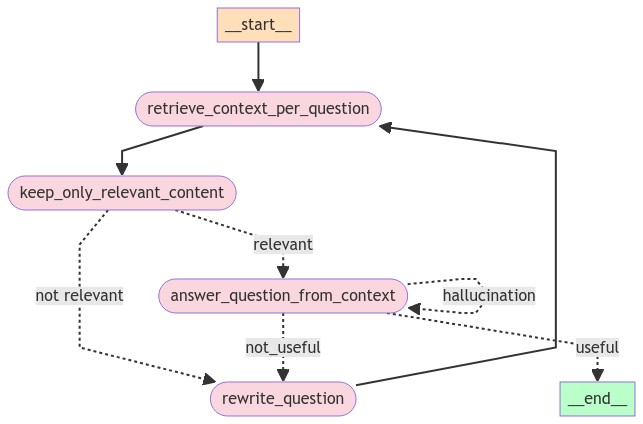

In [186]:
class QualitativeRetievalAnswerGraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        context: context
        answer: answer
    """

    question: str
    context: str
    answer: str

# Create the graph
qualitative_retrieval_answer_workflow = StateGraph(QualitativeRetievalAnswerGraphState)

# Define the nodes

# Add the nodes to the graph
qualitative_retrieval_answer_workflow.add_node("retrieve_context_per_question",retrieve_context_per_question)
qualitative_retrieval_answer_workflow.add_node("keep_only_relevant_content",keep_only_relevant_content)
qualitative_retrieval_answer_workflow.add_node("rewrite_question",rewrite_question)
qualitative_retrieval_answer_workflow.add_node("answer_question_from_context",answer_question_from_context)

# Build the graph
qualitative_retrieval_answer_workflow.set_entry_point("retrieve_context_per_question")
qualitative_retrieval_answer_workflow.add_edge("retrieve_context_per_question", "keep_only_relevant_content")
qualitative_retrieval_answer_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_relevant_content,
    {"relevant":"answer_question_from_context",
      "not relevant":"rewrite_question"},
    )
qualitative_retrieval_answer_workflow.add_edge("rewrite_question", "retrieve_context_per_question")
qualitative_retrieval_answer_workflow.add_conditional_edges(
"answer_question_from_context",
grade_generation_v_documents_and_question,
{"hallucination":"answer_question_from_context",
"not_useful":"rewrite_question",
"useful":END},

)

qualitative_retrieval_answer_retrival_app = qualitative_retrieval_answer_workflow.compile()

display(
    Image(
        qualitative_retrieval_answer_retrival_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# For more complex tasks, we need a more sophisticated pipeline. For this, we may first break down this graph into two subgraphs that will serve as functions for the sophisticated pipline.

### First sub graph would be for retrieval and distillation of the relevant information

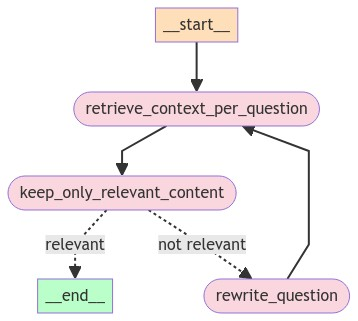

In [187]:
class QualitativeRetrievalGraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        context: context
        answer: answer
    """

    question: str
    context: str

qualitative_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)

# Define the nodes
qualitative_retrieval_workflow.add_node("retrieve_context_per_question",retrieve_context_per_question)
qualitative_retrieval_workflow.add_node("keep_only_relevant_content",keep_only_relevant_content)
qualitative_retrieval_workflow.add_node("rewrite_question",rewrite_question)

# Build the graph
qualitative_retrieval_workflow.set_entry_point("retrieve_context_per_question")
qualitative_retrieval_workflow.add_edge("retrieve_context_per_question", "keep_only_relevant_content")
qualitative_retrieval_workflow.add_edge("rewrite_question", "retrieve_context_per_question")

qualitative_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_relevant_content,
    {"relevant":END,
      "not relevant":"rewrite_question"},
    )


qualitative_retrieval_workflow_app = qualitative_retrieval_workflow.compile()

display(
    Image(
        qualitative_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### The second sub graph will be a component that answers a question given context, without hallucinations

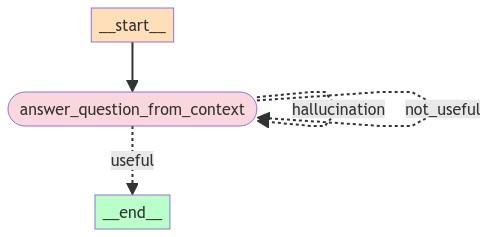

In [188]:
class QualitativeAnswerGraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        context: context
        answer: answer
    """

    question: str
    context: str
    answer: str

qualitative_answer_workflow = StateGraph(QualitativeAnswerGraphState)

# Define the nodes

qualitative_answer_workflow.add_node("answer_question_from_context",answer_question_from_context)

# Build the graph
qualitative_answer_workflow.set_entry_point("answer_question_from_context")

qualitative_answer_workflow.add_conditional_edges(
"answer_question_from_context",
grade_generation_v_documents_and_question,
{"hallucination":"answer_question_from_context",
"not_useful":"answer_question_from_context",
"useful":END},

)

qualitative_answer_workflow_app = qualitative_answer_workflow.compile()

display(
    Image(
        qualitative_answer_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# Now let's define the sophisticated pipline components

### The state of each step of the graph should be in this structure:

In [189]:
class PlanExecute(TypedDict):
    question: str
    anonymized_question: str
    query_to_retrieve_or_answer: str
    plan: List[str]
    past_steps: List[str]
    mapping: dict 
    curr_context: str
    aggregated_context: str
    tool: str
    response: str

### Define the Plan node - constructs a plan composed of steps, of how to tackle a question

In [190]:
class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

planner_prompt =""" For the given query {question}, come up with a simple step by step plan of how to figure out the answer. 

This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. 
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

"""

planner_prompt = PromptTemplate(
    template=planner_prompt,
      input_variables=["question"], 
     )

planner_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)

planner = planner_prompt | planner_llm.with_structured_output(Plan)

### a function to break down each task to either retrieve or answer

In [191]:
break_down_plan_prompt_template = """You receive a plan {plan} which contains a series of steps to follow in order to answer a query. 
you need to go through the plan refine it according to this:
1. every step has to be able to be executed by either retrieving relevant information from a vector store based on a given query, or answering a question from a given context.
2. every step should contain all the information needed to execute it.

output the refined plan
"""

break_down_plan_prompt = PromptTemplate(
    template=break_down_plan_prompt_template,
    input_variables=["plan"],
)

break_down_plan_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)

break_down_plan_chain = break_down_plan_prompt | break_down_plan_llm.with_structured_output(Plan)


### example of how to use the planner


In [135]:
question = {"question": "how did the main character beat the villain?"}
my_plan = planner.invoke(question)
print(my_plan)
refined_plan = break_down_plan_chain.invoke(my_plan.steps)
print(refined_plan)

steps=['Identify the main character and the villain in the story.', 'Find the specific scene or chapter where the main character confronts the villain.', 'Read the scene or chapter carefully to understand the actions taken by the main character.', 'Note down the key actions and strategies used by the main character to defeat the villain.', 'Summarize the key actions and strategies into a concise answer.']
steps=['Retrieve relevant information from a vector store to identify the main character and the villain in the story.', 'Retrieve relevant information from a vector store to find the specific scene or chapter where the main character confronts the villain.', 'Retrieve relevant information from a vector store to read the scene or chapter where the main character confronts the villain.', 'Answer the question from the given context to note down the key actions and strategies used by the main character to defeat the villain.', 'Answer the question from the given context to summarize the 

### Given the original question, the current plan, the past steps and the so far aggregated information, update the plan

In [192]:
class ActPossibleResults(BaseModel):
    """Possible results of the action."""
    plan: Plan = Field(description="Plan to follow in future.")
    explanation: str = Field(description="Explanation of the action.")
    

act_possible_results_parser = JsonOutputParser(pydantic_object=ActPossibleResults)

replanner_prompt_template =""" For the given objective, come up with a simple step by step plan of how to figure out the answer. 
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. 
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

The plan steps should contain either of the following tasks:
1) Retrieve relevant information from a vector store based on a given query.
2) Answer a question from a given context.

assume that the answer was not found yet and you need to update the plan accordingly, so the plan should never be empty.

when building the plan take in account that you have is access to TWO TOOLS:
1) function A: that retrieves both vector stores of chunks of a book and vector stores of the same book chapter summaries for a given query and distills the relevant information.
use this tool to retrieve the relevant documents based on every query you want.

2) function B: answers a question from a given context, based on the retrieved documents, without hallucination.
use this tool to answer the question based on the retrieved documents.


Your objective was this:
{question}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

You already have the following context:
{aggregated_context}

Update your plan accordingly. If further steps are needed, fill out the plan with only those steps.
Do not return previously done steps as part of the plan.

the format is json so escape quotes and new lines.

{format_instructions}

"""

replanner_prompt = PromptTemplate(
    template=replanner_prompt_template,
    input_variables=["question", "plan", "past_steps", "aggregated_context"],
    partial_variables={"format_instructions": act_possible_results_parser.get_format_instructions()},
)

replanner_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)



replanner = replanner_prompt | replanner_llm | act_possible_results_parser

### Define the task handler - decides whether to use the first sub graph or the second sub graph to handle each task from the plan

In [193]:
tasks_handler_prompt_template = """You are a task handler that receives a task {curr_task} and have to decide with tool to use to execute the task.
You have the following tools at your disposal:
Tool A: a tool that retrieves relevant information from a vector store based on a given query.
Tool B: a tool that answers a question from a given context.
You also have aggregated context {aggregated_context} that you can use to make decisions, and use the information from that context as input to the tools.
You also have the past steps {past_steps} that you can use to make decisions and understand the context of the task.
You also have the initial user's question {question} that you can use to make decisions and understand the context of the task.
if you decide to use Tool A, output the query to be used for the tool and also that the tool to be used is Tool A.
if you decide to use Tool B, output the question to be used for the tool, the context, and also that the tool to be used is Tool B.
"""

class TaskHandlerOutput(BaseModel):
    """Output schema for the task handler."""
    query: str = Field(description="The query to be either retrieved from the vector store, or the question that should be answered from context.")
    curr_context: str = Field(description="The context to be based on in order to answer the query.")
    tool: str = Field(description="The tool to be used should be either 'retrieve' or 'answer_from_context'.")


task_handler_prompt = PromptTemplate(
    template=tasks_handler_prompt_template,
    input_variables=["curr_task", "aggregated_context", "past_steps", "question"],
)

task_handler_llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125", max_tokens=2000)
task_handler_chain = task_handler_prompt | task_handler_llm.with_structured_output(TaskHandlerOutput)

### In order to generate general plan, without any biases based on prior knowledge of any LLM, we anonymize the input question first, and mapping the name entities into variables

In [194]:
class AnonymizeQuestion(BaseModel):
    """Anonymized question and mapping."""
    anonymized_question : str = Field(description="Anonymized question.")
    mapping: dict = Field(description="Mapping of original name entities to variables.")
    explanation: str = Field(description="Explanation of the action.")

anonymize_question_parser = JsonOutputParser(pydantic_object=AnonymizeQuestion)


anonymize_question_prompt_template = """ You are a question anonymizer. The input You receive is a string containing several words that
 construct a question {question}. Your goal is to changes all name entities in the input to variables, and remember the mapping of the original name entities to the variables.
 ```example1:
        if the input is \"who is harry potter?\" the output should be \"who is X?\" and the mapping should be {{\"X\": \"harry potter\"}} ```
```example2:
        if the input is \"how did the bad guy played with the alex and rony?\"
          the output should be \"how did the X played with the Y and Z?\" and the mapping should be {{\"X\": \"bad guy\", \"Y\": \"alex\", \"Z\": \"rony\"}}```
 you must replace all name entities in the input with variables, and remember the mapping of the original name entities to the variables.
  output the anonymized question and the mapping in a json format. {format_instructions}"""



anonymize_question_prompt = PromptTemplate(
    template=anonymize_question_prompt_template,
    input_variables=["question"],
    partial_variables={"format_instructions": anonymize_question_parser.get_format_instructions()},
)

anonymize_question_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)
anonymize_question_chain = anonymize_question_prompt | anonymize_question_llm | anonymize_question_parser

### After the plan in constructed based on the anonymized question, we de-anonymize the plan, using the mapped variables

In [195]:
class DeAnonymizePlan(BaseModel):
    """Possible results of the action."""
    plan: List = Field(description="Plan to follow in future. with all the variables replaced with the mapped words.")
    # explanation: str = Field(description="Explanation of the action.")

deanonymize_plan_parser = JsonOutputParser(pydantic_object=DeAnonymizePlan)


de_anonymize_plan_prompt_template = """ you receive a list of tasks: {plan}, where some of the words are replaced with mapped variables. you also receive
the mapping for those variables to words {mapping}. replace all the variables in the list of tasks with the mapped words. if no variables are present,
return the original list of tasks. in any case, just output the updated list of tasks in a json format as described here, without any additional text apart from the
"""


de_anonymize_plan_prompt = PromptTemplate(
    template=de_anonymize_plan_prompt_template,
    input_variables=["plan", "mapping"],
    # partial_variables={"format_instructions": deanonymize_plan_parser.get_format_instructions()},
)

# de_anonymize_plan_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=2000)
de_anonymize_plan_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)
de_anonymize_plan_chain = de_anonymize_plan_prompt | de_anonymize_plan_llm.with_structured_output(DeAnonymizePlan)

### example of how to use the de_anonymize_plan_chain


In [82]:
state1 = {'question': "how did the main characther beat the villain?"}
anonymized_question_output = anonymize_question_chain.invoke(state1)
anonymized_question = anonymized_question_output["anonymized_question"]
mapping = anonymized_question_output["mapping"]
print(f'anonimized_querry: {anonymized_question}')
print(f'mapping: {mapping}')
plan = planner.invoke({"question": anonymized_question})
print(f'plan: {plan.steps}')
deanonimzed_plan = de_anonymize_plan_chain.invoke({"plan": plan.steps, "mapping": mapping})
print(f'deanonimized_plan: {deanonimzed_plan.plan}')

anonimized_querry: how did the X beat the Y?
mapping: {'X': 'main character', 'Y': 'villain'}
plan: ["Retrieve relevant information from a vector store based on the query 'How did X beat Y?' using function A.", "Answer the question 'How did X beat Y?' from the retrieved context using function B."]
deanonimized_plan: ["Retrieve relevant information from a vector store based on the query 'How did main character beat villain?' using function A.", "Answer the question 'How did main character beat villain?' from the retrieved context using function B."]


### A function that checks if the final answer can be deduced already, based on the aggregated information

In [196]:
class CanBeAnsweredAlready(BaseModel):
    """Possible results of the action."""
    can_be_answered: bool = Field(description="Whether the question can be fully answered or not based on the given context.")
    explanation: str = Field(description="Explanation of the action.")

can_be_answered_already_prompt_template = """You receive a query: {question} and a context: {context}.
You need to determine if the question can be fully answered relying only the given context.
The only infomation you have and can rely on is the context you received. 
you have no prior knowledge of the question or the context.
if you think the question can be fully answered, output 'true', otherwise output 'false'.
make it plausible. don't output 'true' with too few information, but also don't require too much information to output 'true'.
{format_instructions}"""

can_be_answered_json_parser = JsonOutputParser(pydantic_object=CanBeAnsweredAlready)

can_be_answered_already_prompt = PromptTemplate(
    template=can_be_answered_already_prompt_template,
    input_variables=["question","context"],
    partial_variables={"format_instructions": can_be_answered_json_parser.get_format_instructions()},
)

can_be_answered_already_llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125", max_tokens=2000)
can_be_answered_already_chain = can_be_answered_already_prompt | can_be_answered_already_llm | can_be_answered_json_parser

### Define the sophisticated pipeline graph functions

In [208]:
def run_task_handler_chain(state: PlanExecute):
    """ Runs the task handler chain. """
    print("the current plan is:")
    print(state["plan"])
    pprint("--------------------") 

    if not state['past_steps']:
        state["past_steps"] = []

    curr_task = state["plan"][0]

    inputs = {"curr_task": curr_task,
               "aggregated_context": state["aggregated_context"],
                "past_steps": state["past_steps"],
                "question": state["question"]}
    
    output = task_handler_chain.invoke(inputs)
  
    state["past_steps"].append(curr_task)
    state["plan"].pop(0)

    if output.tool == "retrieve":
        state["query_to_retrieve_or_answer"] = output.query
        state["tool"]="retrieve"
    elif output.tool == "answer_from_context":
        state["query_to_retrieve_or_answer"] = output.query
        state["context"] = output.curr_context
        state["tool"]="answer"
    else:
        raise ValueError("Invalid tool was outputed. Must be either 'retrieve' or 'answer_from_context'")
    return state  

def retrieve_or_answer(state: PlanExecute):
    print("deciding whether to retrieve or answer")
    if state["tool"] == "retrieve":
        return "retrieve_from_vector_store"
    elif state["tool"] == "answer":
        return "answer_from_context"
    else:
        raise ValueError("Invalid tool was outputed. Must be either 'retrieve' or 'answer_from_context'")  


def run_qualitative_retrieval_workflow(state):
    print("Running the qualitative retrieval workflow...")
    question = state["query_to_retrieve_or_answer"]
    inputs = {"question": question}
    for output in qualitative_retrieval_workflow_app.stream(inputs):
        for _, value in output.items():
            pass  # Node
            # ... (your existing code)
        pprint("--------------------")
    
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += value
    return state



def run_qualtative_answer_workflow(state):
    print("Running the qualitative answer workflow...")
    question = state["query_to_retrieve_or_answer"]
    context = state["curr_context"]
    inputs = {"question": question, "context": context}
    for output in qualitative_answer_workflow_app.stream(inputs):
        for _, value in output.items():
            pass  # Node
        pprint("--------------------")
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += value
    return state

def run_qualtative_answer_workflow_for_final_answer(state):
    print("Running the qualitative answer workflow for final answer...")
    question = state["question"]
    context = state["aggregated_context"]
    inputs = {"question": question, "context": context}
    for output in qualitative_answer_workflow_app.stream(inputs):
        for _, value in output.items():
            pass  # Node
        pprint("--------------------")
    state["response"] = value
    return state


def anonymize_queries(state: PlanExecute):
    print("Anonymizing question")
    pprint("--------------------")
    anonymized_question_output = anonymize_question_chain.invoke(state['question'])
    anonymized_question = anonymized_question_output["anonymized_question"]
    print(f'anonimized_querry: {anonymized_question}')
    mapping = anonymized_question_output["mapping"]
    state["anonymized_question"] = anonymized_question
    state["mapping"] = mapping
    return state

def deanonymize_queries(state: PlanExecute):
    print("De-anonymizing plan")
    pprint("--------------------")
    deanonimzed_plan = de_anonymize_plan_chain.invoke({"plan": state["plan"], "mapping": state["mapping"]})
    state["plan"] = deanonimzed_plan.plan
    print(f'de-anonimized_plan: {deanonimzed_plan.plan}')
    return state


def plan_step(state: PlanExecute):
    print("Planning step")
    pprint("--------------------")
    plan = planner.invoke({"question": state['anonymized_question']})
    state["plan"] = plan.steps
    print(f'plan: {state["plan"]}')
    return state

def break_down_plan_step(state: PlanExecute):
    print("Breaking down plan steps into retrievable or answerable tasks")
    pprint("--------------------")
    refined_plan = break_down_plan_chain.invoke(state["plan"])
    state["plan"] = refined_plan.steps
    return state


def replan_step(state: PlanExecute):
    print("Replanning step")
    pprint("--------------------")
    inputs = {"question": state["question"], "plan": state["plan"], "past_steps": state["past_steps"], "aggregated_context": state["aggregated_context"]}
    output = replanner.invoke(inputs)
    state["plan"] = output['plan']['steps']
    return state

def can_be_answered(state: PlanExecute):
    print("Checking if the ORIGINAL QUESTION can be answered already")
    pprint("--------------------")
    question = state["question"]
    context = state["aggregated_context"]
    inputs = {"question": question, "context": context}
    output = can_be_answered_already_chain.invoke(inputs)
    if output["can_be_answered"] == True:
        print("The ORIGINAL QUESTION can be fully answered already.")
        pprint("--------------------")
        print("the aggregated context is:")
        print(text_wrap(state["aggregated_context"]))
        print("--------------------")
        return "can_be_answered_already"
    else:
        print("The ORIGINAL QUESTION cannot be fully answered yet.")
        pprint("--------------------")
        return "cannot_be_answered_yet"

### Define the sophisticated graph structure

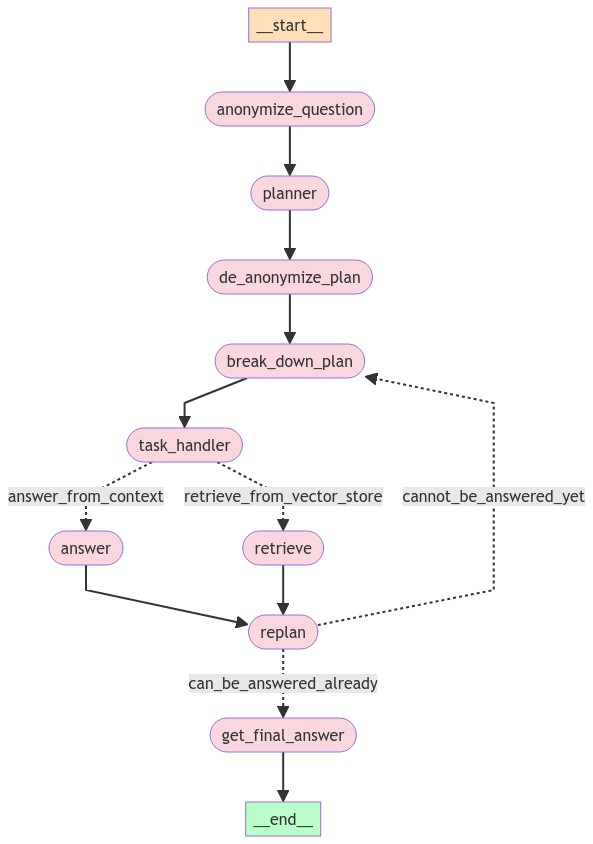

In [209]:
from langgraph.graph import StateGraph

agent_workflow = StateGraph(PlanExecute)

# Add the anonymize node
agent_workflow.add_node("anonymize_question", anonymize_queries)

# Add the plan node
agent_workflow.add_node("planner", plan_step)

# Add the break down plan node

agent_workflow.add_node("break_down_plan", break_down_plan_step)

# Add the deanonymize node
agent_workflow.add_node("de_anonymize_plan", deanonymize_queries)

# Add the qualitative retrieval node
agent_workflow.add_node("retrieve", run_qualitative_retrieval_workflow)

# Add the qualitative answer node
agent_workflow.add_node("answer", run_qualtative_answer_workflow)

# Add the task handler node
agent_workflow.add_node("task_handler", run_task_handler_chain)

# Add a replan node
agent_workflow.add_node("replan", replan_step)

# Add answer from context node
agent_workflow.add_node("get_final_answer", run_qualtative_answer_workflow_for_final_answer)



# Set the entry point
agent_workflow.set_entry_point("anonymize_question")

# From anonymize we go to plan
agent_workflow.add_edge("anonymize_question", "planner")

# From plan we go to deanonymize
agent_workflow.add_edge("planner", "de_anonymize_plan")

# From deanonymize we go to break down plan

agent_workflow.add_edge("de_anonymize_plan", "break_down_plan")

# From break_down_plan we go to task handler
agent_workflow.add_edge("break_down_plan", "task_handler")

# From task handler we go to either retrieve or answer
agent_workflow.add_conditional_edges("task_handler", retrieve_or_answer, {"retrieve_from_vector_store": "retrieve", "answer_from_context": "answer"})

# After retrieving we go to replan
agent_workflow.add_edge("retrieve", "replan")

# After answering we go to replan
agent_workflow.add_edge("answer", "replan")

# After replanning we check if the question can be answered, if yes we go to get_final_answer, if not we go to task_handler
agent_workflow.add_conditional_edges("replan",can_be_answered, {"can_be_answered_already": "get_final_answer", "cannot_be_answered_yet": "break_down_plan"})

# After getting the final answer we end
agent_workflow.add_edge("get_final_answer", END)


plan_and_execute_app = agent_workflow.compile()



display(Image(plan_and_execute_app.get_graph(xray=True).draw_mermaid_png()))

### Run the sophisticated graph function

In [210]:
def execute_plan_and_print_steps(inputs, recursion_limit=20):
    config = {"recursion_limit": recursion_limit}
    try:    
        for plan_output in plan_and_execute_app.stream(inputs, config=config):
            for _, agent_state_value in plan_output.items():
                pass
                # print(f' curr step: {agent_state_value}')
        plan_output = agent_state_value['response']
    except langgraph.pregel.GraphRecursionError:
        plan_output = "The answer wasn't found in the data."
    final_state = agent_state_value
    return plan_output, final_state

### Examples

In [211]:
inputs = {"question": "how did harry beat quirrell?"}
final_answer, final_state = execute_plan_and_print_steps(inputs)
print(text_wrap(f'The final answer is: {final_answer}'))

Anonymizing question
'--------------------'
anonimized_querry: how did X beat Y?
Planning step
'--------------------'
plan: ['Identify the context or domain of the query (e.g., sports, business, technology).', 'Gather information about X and Y within the identified context.', 'Collect data on the event or scenario where X and Y were in competition.', 'Analyze the performance or actions of X and Y during the event or scenario.', "Compare the performance or actions of X and Y to determine the key factors that led to X's victory.", 'Summarize the key factors and present the final answer.']
De-anonymizing plan
'--------------------'
de-anonimized_plan: ['Identify the context or domain of the query (e.g., sports, business, technology).', 'Gather information about harry and quirrell within the identified context.', 'Collect data on the event or scenario where harry and quirrell were in competition.', 'Analyze the performance or actions of harry and quirrell during the event or scenario.', "C

In [177]:
inputs = {"question": "how did the main character beat the villain?"}
final_answer, final_state = execute_plan_and_print_steps(inputs)
print(text_wrap(f'The final answer is: {final_answer}'))

Anonymizing question
'--------------------'
anonimized_querry: how did the X beat the Y?
Planning step
'--------------------'
plan: ['Identify the specific event or context in which X beat Y.', 'Gather detailed information about the event, including date, location, and participants.', 'Analyze the performance or actions of X and Y during the event.', "Compare the key factors that contributed to X's victory over Y.", 'Summarize the findings to explain how X beat Y.']
De-anonymizing plan
'--------------------'
Breaking down plan steps into retrievable or answerable tasks
'--------------------'
the current plan is:
['Retrieve information about the specific event or context in which the main character beat the villain from a vector store based on the query.', 'Retrieve detailed information about the event, including date, location, and participants, from a vector store based on the query.', 'Retrieve information to analyze the performance or actions of the main character and villain during

In [200]:
inputs = {"question": "who is charles darwin?"}
final_answer = execute_plan_and_print_steps(inputs)
print(f'The final answer is: {final_answer}')


Anonymizing question
'--------------------'
anonimized_querry: who is X?
Planning step
'--------------------'
plan: ["Identify the context or domain related to 'X'.", 'Gather information from reliable sources within the identified context or domain.', 'Verify the gathered information for accuracy and relevance.', "Compile the verified information to form a comprehensive answer about 'X'."]
De-anonymizing plan
'--------------------'
Breaking down plan steps into retrievable or answerable tasks
'--------------------'
the current plan is:
["Identify the context or domain related to 'charles darwin' by retrieving relevant information from a vector store based on the query 'charles darwin'.", "Gather information from reliable sources within the identified context or domain by retrieving relevant information from a vector store based on the context 'charles darwin'.", "Verify the gathered information for accuracy and relevance by answering questions from the given context 'charles darwin'.",

In [35]:
input = {"question": "what did professor lupin teach?"}
final_answer, final_state = execute_plan_and_print_steps(input)
print(f'The final answer is: {final_answer}')

Anonymizing question
'--------------------'
Planning step
'--------------------'
De-anonymizing plan
'--------------------'
the current plan is:
["Retrieve relevant information from a vector store based on the query 'What did professor Lupin teach?'.", "Answer the question 'What did professor Lupin teach?' from the retrieved context."]
'--------------------'
deciding whether to retrieve or answer
Running the qualitative retrieval workflow...
'--------------------'
'--------------------'
Retrieving relevant chunks...
Retrieving relevant chapter summaries...
'--------------------'
keeping only the relevant content...
Determining if the document is relevant...
The document is not relevant.
'--------------------'
Rewriting the question...
'--------------------'
Retrieving relevant chunks...
Retrieving relevant chapter summaries...
'--------------------'
keeping only the relevant content...
Determining if the document is relevant...
The document is relevant.
'--------------------'
Replannin

### Template for Answering Questions Using Context-Specific Information


### Model Evaluation


In [ ]:
questions = [
    "Who gave Harry Potter his first broomstick?",
    "What is the name of the three-headed dog guarding the Sorcerer's Stone?",
    "Which house did the Sorting Hat initially consider for Harry?",
    "What is the name of Harry's owl?"
]
#     "How did Harry and his friends get past Fluffy?",
#     "What is the Mirror of Erised?",
#     "Who tried to steal the Sorcerer's Stone?",
#     "How did Harry defeat Quirrell?",
#     "What is Harry's parent's secret weapon against Voldemort?",
# ]

ground_truth_answers = [
    "Professor McGonagall",
    "Fluffy",
    "Slytherin",
    "Hedwig",
    # "They played music to put Fluffy to sleep.",
    # "A magical mirror that shows the 'deepest, most desperate desire of our hearts.'",
    # "Professor Quirrell, possessed by Voldemort",
    # "Harry's mother's love protected him, causing Quirrell/Voldemort pain when they touched him.",
    
]

### Generating Answers and Retrieving Documents for Predefined Questions


In [ ]:
generated_answers = []
retrieved_documents = []
for question in questions:
    result, all_context_book, all_context_summaries = answer_question_pipeline(question, chunks_retriever, chapter_summaries_retriever, answer_from_context_llm_chain, multi_query_retriver_llm)
    generated_answers.append(result['text'])
    retrieved_documents.append(all_context_book + all_context_summaries)


### Displaying Retrieved Documents and Generated Answers


In [ ]:
print(f'retrieved_documents: {retrieved_documents}\n')
print(f'generated_answers: {generated_answers}')

### Preparing Data and Conducting Ragas Evaluation


In [ ]:
# Prepare data for Ragas evaluation
data_samples = {
    'question': questions,  # Replace with your list of questions
    'answer': generated_answers,  # Replace with your list of generated answers
    'contexts': retrieved_documents,  # Your retrieved_documents list
    'ground_truth': ground_truth_answers  # Replace with your list of ground truth answers
}

# Convert contexts to list of strings (if necessary)
data_samples['contexts'] = [list(context) for context in data_samples['contexts']]

dataset = Dataset.from_dict(data_samples)

# Evaluate using Ragas with the specified metrics
metrics = [
    answer_correctness,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_similarity
]
llm = ChatOpenAI(temperature=0, model_name="gpt-4-1106-preview", max_tokens=4000)
score = evaluate(dataset, metrics=metrics, llm=llm)

# Print results and explanations
results_df = score.to_pandas()
print(results_df)

### Analyzing Metric Results from Ragas Evaluation


In [ ]:
analyse_metric_results(results_df)